# Classification: How effective is online education? 

In [25]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report,ConfusionMatrixDisplay


In [11]:
df = pd.read_csv('students_adaptability_level_online_education.csv')
df

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
0,Boy,21-25,University,Non Government,No,Yes,Low,Mid,Wifi,4G,3-6,No,Tab,Moderate
1,Girl,21-25,University,Non Government,No,Yes,High,Mid,Mobile Data,4G,1-3,Yes,Mobile,Moderate
2,Girl,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Moderate
3,Girl,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile,Moderate
4,Girl,16-20,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,0,No,Mobile,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,Girl,16-20,College,Non Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Low
1201,Girl,16-20,College,Non Government,No,No,High,Mid,Wifi,4G,3-6,No,Mobile,Moderate
1202,Boy,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,3G,1-3,No,Mobile,Moderate
1203,Girl,16-20,College,Non Government,No,No,Low,Mid,Wifi,4G,1-3,No,Mobile,Low


In [12]:
df.shape  #1205 rows, 14 col 

(1205, 14)

In [13]:
df.dtypes

Gender                 object
Age                    object
Education Level        object
Institution Type       object
IT Student             object
Location               object
Load-shedding          object
Financial Condition    object
Internet Type          object
Network Type           object
Class Duration         object
Self Lms               object
Device                 object
Adaptivity Level       object
dtype: object

## Feature engineering

In [14]:
# step 1: handling missing values 
df.isnull().sum() # no missing values 

df.rename(columns = {'Adaptivity Level':'adaptivity'}, inplace = True)


Text(0.5, 1.0, 'Original Adaptivity distributions')

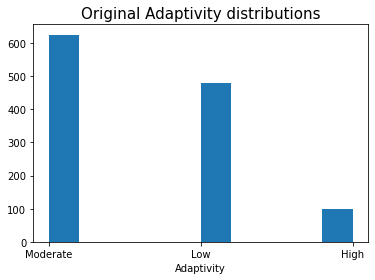

In [15]:
# plot histogram
plt.figure()
plt.hist(df.adaptivity)
plt.xlabel("Adaptivity")
plt.title("Original Adaptivity distributions", size=15)

In [8]:
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.347533,0.398948,0.455743,0.072914,-0.233402,-0.731222,0.477978,-0.442621,0.015185
1,0.347533,1.000000,-0.284056,0.571003,-0.285483,0.382480,-0.362842,0.642578,0.252556,0.190047
2,0.398948,-0.284056,1.000000,-0.523649,0.152937,-0.139176,-0.092895,0.016266,-0.434016,-0.383585
3,0.455743,0.571003,-0.523649,1.000000,-0.225343,-0.227577,-0.481548,0.473286,0.279258,0.446650
4,0.072914,-0.285483,0.152937,-0.225343,1.000000,-0.104438,-0.147477,-0.523283,-0.614603,-0.189916
5,-0.233402,0.382480,-0.139176,-0.227577,-0.104438,1.000000,-0.030252,0.417640,0.205851,0.095084
6,-0.731222,-0.362842,-0.092895,-0.481548,-0.147477,-0.030252,1.000000,-0.494440,0.381407,-0.353652
7,0.477978,0.642578,0.016266,0.473286,-0.523283,0.417640,-0.494440,1.000000,0.375873,0.417863
8,-0.442621,0.252556,-0.434016,0.279258,-0.614603,0.205851,0.381407,0.375873,1.000000,0.150421
9,0.015185,0.190047,-0.383585,0.446650,-0.189916,0.095084,-0.353652,0.417863,0.150421,1.000000


### One hot encoding 

Since all variables are categorical, we need to convert them to numerical. One hot encoding means create additional dummy variables for each unique value in the set of the categorical feature we are encoding. 

I did not use label encoding since I will be using regression and distance metrics which are only for one hot encoding. 

In [45]:
onehotencoded_df = pd.get_dummies(df, columns = ['Gender', 'Age', 'Education Level', 'Institution Type', 'IT Student',
       'Location', 'Load-shedding', 'Financial Condition', 'Internet Type',
       'Network Type', 'Class Duration', 'Self Lms', 'Device']) 
onehotencoded_df['adaptivity']=onehotencoded_df['adaptivity'].map({'Moderate':2,'Low':1,'High':0})  # label encode for predictor only
onehotencoded_df.head()  # 36 columns 

,adaptivity,Gender_Boy,Gender_Girl,Age_1-5,Age_11-15,Age_16-20,Age_21-25,Age_26-30,Age_6-10,Education Level_College,...,Network Type_3G,Network Type_4G,Class Duration_0,Class Duration_1-3,Class Duration_3-6,Self Lms_No,Self Lms_Yes,Device_Computer,Device_Mobile,Device_Tab
0,2,1,0,0,0,0,1,0,0,0,...,0,1,0,0,1,1,0,0,0,1
1,2,0,1,0,0,0,1,0,0,0,...,0,1,0,1,0,0,1,0,1,0
2,2,0,1,0,0,1,0,0,0,1,...,0,1,0,1,0,1,0,0,1,0
3,2,0,1,0,1,0,0,0,0,0,...,0,1,0,1,0,1,0,0,1,0
4,1,0,1,0,0,1,0,0,0,0,...,1,0,1,0,0,1,0,0,1,0


In [46]:
X=onehotencoded_df.iloc[:,1:]
y=onehotencoded_df.iloc[:,:1]
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3,random_state=42)


# Feature selection 

Before we start building models, we should do try and look at the relationship of variables. Since adaptivity is the main target variable we are trying to find out, I want to see which variables are most correlated to adaptivity(positive and negative). Feature selection aims to find out which variables are not important and aim to exclude them from model building.



### 1) Lasso L1 (for logistic regression)

Regularisation means adding a penalty to the different parameters of the model to reduce the freedom of the model and in other words to avoid overfitting. 

In linear model regularisation, the penalty is applied over the coefficients that multiply each of the predictors. From the different types of regularisation, Lasso or L1 has the property that is able to shrink some of the coefficients to zero. Therefore, that feature can be removed from the model.

### Method 1: PCA 

Since there are 36 features after one hot encoding, to avoid dummy variable trap, we should try to scale down number of features. With PCA, I was able to scale down to top 20 principal components that explain about 99% of variance. 

In [68]:
x = onehotencoded_df.iloc[:,1:]
y = onehotencoded_df.iloc[:,:1]

# standardize features/predictors before PCA 
scaler = StandardScaler()
x = StandardScaler().fit_transform(x)

# minimum number of PCs 
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = [f"PC{i}" for i in range(1, 21)])
PCA_df = pd.concat([principalDf, onehotencoded_df[['adaptivity']]], axis = 1)


# Determining how many pc to take # 20 PCs
# pca.fit(x)

# # Get the eigenvalues
# print("Eigenvalues:")
# print(pca.explained_variance_)
# print()

# # Get explained variances
# print("Variances (Percentage):")
# print(pca.explained_variance_ratio_ * 100)
# print()

# # Make the scree plot
# plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
# plt.xlabel("Number of components (Dimensions)")
# plt.ylabel("Explained variance (%)")


In [69]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(principalDf, y, test_size=0.30,random_state=42)


Here I will go directly into model building, but first, we will do hyperparameter tuning to see what parameters we should use got our logistic reg. 

In [73]:
# # hyperparameter tuning
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RepeatedStratifiedKFold

# # define model
# model = LogisticRegression()
# # define eval
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
# # define search space
# space = dict()
# space['solver'] = ['lbfgs', 'liblinear']
# space['penalty'] = ['l1', 'l2', 'elasticnet']
# space['C'] = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
# # define search
# search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)
# # execute search
# result = search.fit(X_train_pca, y_train)
# # summarize result
# print('Best Score: %s' % result.best_score_)
# print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.6951500422654269

Best Hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}

### Model building: Logistic regression with PCA

In [82]:
clf=LogisticRegression(C=10, penalty='l2', solver='lbfgs')
clf.fit(X_train_pca, y_train)
y_pred=clf.predict(X_test_pca)
# print(classification_report(y_test,pred, zero_division=1))

y_true = y_test # True values

# Measure accuracy
from sklearn.metrics import accuracy_score
import numpy as np
print("Train accuracy:", np.round(accuracy_score(y_train, clf.predict(X_train_pca)), 2))
print("Test accuracy:", np.round(accuracy_score(y_true, y_pred), 2))

# Make the confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print("\nTest confusion_matrix")

print(classification_report(y_true, y_pred, zero_division=1))

Train accuracy: 0.71
Test accuracy: 0.68

Test confusion_matrix
              precision    recall  f1-score   support

           0       0.72      0.33      0.46        39
           1       0.74      0.62      0.67       154
           2       0.64      0.82      0.72       169

    accuracy                           0.68       362
   macro avg       0.70      0.59      0.62       362
weighted avg       0.69      0.68      0.67       362



/Users/charmainelee/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charmainelee/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Method 2: Lasso L1 (for logistic regression)

Regularisation means adding a penalty to the different parameters of the model to reduce the freedom of the model and in other words to avoid overfitting. 

In linear model regularisation, the penalty is applied over the coefficients that multiply each of the predictors. From the different types of regularisation, Lasso or L1 has the property that is able to shrink some of the coefficients to zero. Therefore, that feature can be removed from the model.

Here I used lasso L1 for feature selection instead.

In [95]:
# scaling data
scaler = StandardScaler()
scaler.fit(X_train.fillna(0))

clf=LogisticRegression(C=1, penalty='l1', solver='liblinear')
sel_ = SelectFromModel(clf)
sel_.fit(scaler.transform(X_train.fillna(0)), y_train) #select features with non zero coef

# select features 
selected_feat = X_train.columns[(sel_.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

total features: 35
selected features: 33
features with coefficients shrank to zero: 23


/Users/charmainelee/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [96]:
X_train_selected = sel_.transform(X_train.fillna(0))
X_test_selected = sel_.transform(X_test.fillna(0))
X_train_selected.shape, X_test_selected.shape  # selected features 

/Users/charmainelee/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/charmainelee/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


((843, 33), (362, 33))

In [97]:
clf.fit(X_train_selected,y_train.values.ravel())
pred=clf.predict(X_test_selected)
print(classification_report(y_test,pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.75      0.31      0.44        39
           1       0.73      0.58      0.65       154
           2       0.62      0.82      0.71       169

    accuracy                           0.67       362
   macro avg       0.70      0.57      0.60       362
weighted avg       0.68      0.67      0.65       362



Using PCA or lasso for feature selection doesnt seem to give much difference. In fact, PCA gave slightly better f1 score (0.68>0.67). Perhaps trying other classifiers like SVM or tree based methods might help. 

## SVM

## Decision tree 

## Random forest